# Clouds classification

## 1. Introduction

Understanding Clouds from Satellite Images
https://www.kaggle.com/c/understanding_cloud_organization

The goal is to classify each pixel in the test images to one of the 4(labels)+1(background). 
 
The training images are images of clouds that could have 0,1,2,3,4 labels in each of them and pixels masks to show the location of the labels. In the test images we want to find the where (x,y) and what (label). This is a semantic segmentation problem.

For every training image we have inputs the image values (I), x position, y position and the target is one of 5 labels. The goal in the end is to have an image where every pixel position will have a probability of having each of the labels. The highest probability is the final label for that pixel.

## 2. Data description

train.csv - the run length encoded segmentations for each image-label pair in the train_images

train_images.zip - folder of training images

test_images.zip - folder of test images
The task is to predict the segmentations masks of each of the 4 cloud types (labels) for each image. 
IMPORTANT: Your prediction masks should be scaled down to 350 x 525 px.

sample_submission.csv - a sample submission file in the correct format

## 3. Read and manipulate data

In [3]:
# Load the libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import json
import albumentations as albu
import keras
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, Dropout, concatenate, Flatten
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
%matplotlib notebook
from collections import defaultdict
from PIL import Image
from pathlib import Path
from segmentation_models import Unet
from segmentation_models import get_preprocessing
import segmentation_models as sm
from keras import backend as K
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Nadam
from keras.callbacks import Callback, ModelCheckpoint
from tqdm import tqdm

### 3.1. Segmentation and label information files

In [4]:
train_initial_file = pd.read_csv('Clouds/train.csv')
train_initial_file.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


Encoded pixel is a list of pairs of starting pixels and amount of pixels 
to take in consideration, so basically a mask. The masks are not just 
rectangle or square shapes.

In [5]:
# There are 2 columns in the csv, one is the ImageNameLabel and the other is EncodedPixels
print(train_initial_file.shape)
print(train_initial_file.columns)
print('There are',train_initial_file.shape[0],'images in train.csv')

(22184, 2)
Index(['Image_Label', 'EncodedPixels'], dtype='object')
There are 22184 images in train.csv


In [6]:
# The file names are imagename.jpg_label, so for every whole image we have several subimages.
# Disconnect the name and label so we can use one - hot encoding for the labels
# Not all images have all the different labels, that is why there are 'NaN' in the EncodedPixels columns.
# First remove the 'NaN' and then remove everything before each label in the Image_Label so we can have the labels alone.

# I want to create a new matrix so copy the train_df
train_df=train_initial_file.copy()
train_df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [7]:
# How many empty subimages are in the training images
len(train_df[train_df['EncodedPixels'].isnull()])

10348

In [8]:
# remove the 'NaN'
train_df = train_df[~train_df['EncodedPixels'].isnull()]

In [9]:
print(train_df.shape)
train_df.head()

(11836, 2)


,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...
5,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...
7,002be4f.jpg_Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...


Create 2 new columns, one with the image name and one with the image label.

In [10]:
train_df['ImageId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[1])

In [11]:
# check the new size of the matrix
print(train_df.shape)
train_df.head()

(11836, 4)


,Image_Label,EncodedPixels,ImageId,ClassId
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish
5,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...,002be4f.jpg,Flower
7,002be4f.jpg_Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...,002be4f.jpg,Sugar


In [12]:
# Find how many times each label shows up in the dataset
train_df['ClassId'].value_counts()

Sugar     3751
Gravel    2939
Fish      2781
Flower    2365
Name: ClassId, dtype: int64

In [13]:
# Find the unique label names (for use later)
unique_labels=train_df['ClassId'].unique() # the unique names list
unique_labels

array(['Fish', 'Flower', 'Sugar', 'Gravel'], dtype=object)

In [14]:
# turn the ClassId to one-hot encoding
dummy_train=pd.get_dummies(train_df['ClassId'])
dummy_train.head()

,Fish,Flower,Gravel,Sugar
0,1,0,0,0
1,0,1,0,0
4,1,0,0,0
5,0,1,0,0
7,0,0,0,1


In [15]:
# connect the dummy array to the original array
train_ohe = pd.concat([train_df,dummy_train],axis=1)
train_ohe.head()

,Image_Label,EncodedPixels,ImageId,ClassId,Fish,Flower,Gravel,Sugar
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,1,0,0,0
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,0,1,0,0
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,1,0,0,0
5,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...,002be4f.jpg,Flower,0,1,0,0
7,002be4f.jpg_Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...,002be4f.jpg,Sugar,0,0,0,1


In [16]:
# drop the ClassId column since we have the information in the other columns
train = train_ohe.drop(['ClassId'], axis=1)
train.head()

,Image_Label,EncodedPixels,ImageId,Fish,Flower,Gravel,Sugar
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,1,0,0,0
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,0,1,0,0
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,1,0,0,0
5,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...,002be4f.jpg,0,1,0,0
7,002be4f.jpg_Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...,002be4f.jpg,0,0,0,1


In [17]:
# this will group the images by image id and have 1-hot encoding columns for each label
mask_count_df=train.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.head()

,ImageId,Fish,Flower,Gravel,Sugar
0,0011165.jpg,1,1,0,0
1,002be4f.jpg,1,1,0,1
2,0031ae9.jpg,1,1,0,1
3,0035239.jpg,0,1,1,0
4,003994e.jpg,1,0,1,1


### 3.2. Visualize images

In [18]:
# Check the size of each image in the dataset by iterating through all the training images
train_size_dict = defaultdict(int)
train_path = Path("Clouds/train_images/")

for image1_name in train_path.iterdir():
    image1 = Image.open(image1_name)
    train_size_dict[image1.size] += 1
    
# size of the training set and size of the images
train_size_dict

defaultdict(int, {(2100, 1400): 5546})

<IPython.core.display.Javascript object>


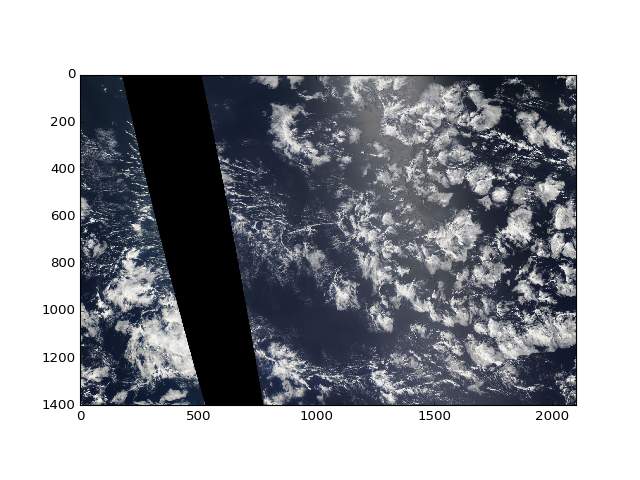

In [19]:
#Visualize an image from the list
image2=Image.open("Clouds/train_images/7da0944.jpg")
plt.imshow(image2)
plt.show()

<IPython.core.display.Javascript object>


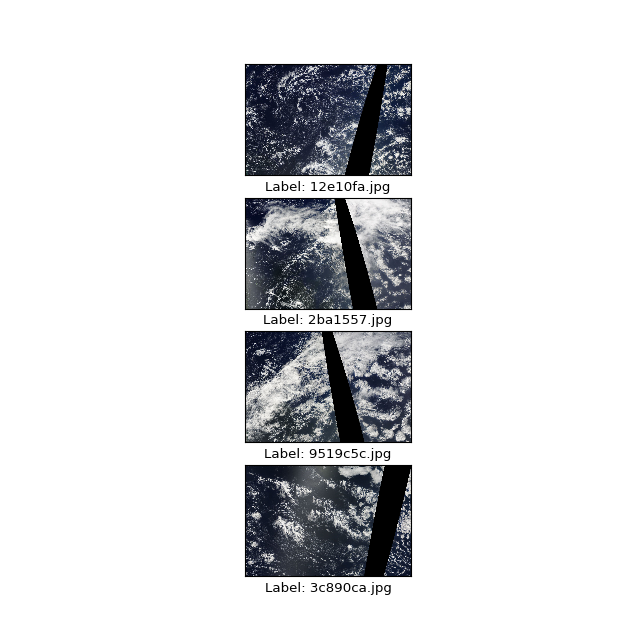

In [20]:
# this is where the training images are located
path1_train='Clouds/train_images/'
# plot num2 random images
fig1 = plt.figure(figsize=(8, 8))
num2=4 # number of images to be shown
for index2, image_id2 in enumerate(np.random.choice(train_df['ImageId'].unique(), num2)):
    ax1 = fig1.add_subplot(num2, 1, index2+1, xticks=[], yticks=[])
    random_image2_withpath=path1_train+image_id2
    image2=Image.open(random_image2_withpath)
    plt.xlabel('Label: {}'.format(image_id2))
    plt.imshow(image2)
    plt.show()

### 3.3. Encoded pixels and masks

Encoded Pixels are different than masks. The first few elements:

264918 937 266318 937 267718 937 269118 937 270518 937 

means take 937 pixels starting from 264918, take 937 pixels starting from 266318 and son on.

So I need to write a function to transform the encoded pixels to masks, as well as the opposite transform.

In [21]:
# Write a function to turn the EncodedPixels to masks
def rle2mask(encoded_pixels,height,width):
# Parameters:
# encoded_pixels,height,width
# Returns:
# nmask : binary mask
        rows,cols = height,width
        if encoded_pixels == -1:
            return np.zeros((height,width))
        else:   
            rle_num = list(map(int, encoded_pixels.split(' ')))
            # split the numbers and turn them to integers
            rle_pairs = np.array(rle_num).reshape(-1,2) 
            nmask_img = np.zeros((rows*cols,1), dtype=int) 
            # create a zero mask to fill
            for index, length in rle_pairs:
                index -= 1 
                nmask_img[index:index+length] = 1 # also can be 255
            nmask=np.reshape(nmask_img,(cols,rows)).T
            return nmask

In [22]:
# Write a function that turns a mask to EncodedPixels
def mask2rle(mask):
#Parameters: 
#    mask (numpy.array): binary mask of numpy array where 1 - mask, 0 - background

#    Returns: run length encoding 
    pixels= mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

To check the function, plot num3 images with their masks

<IPython.core.display.Javascript object>


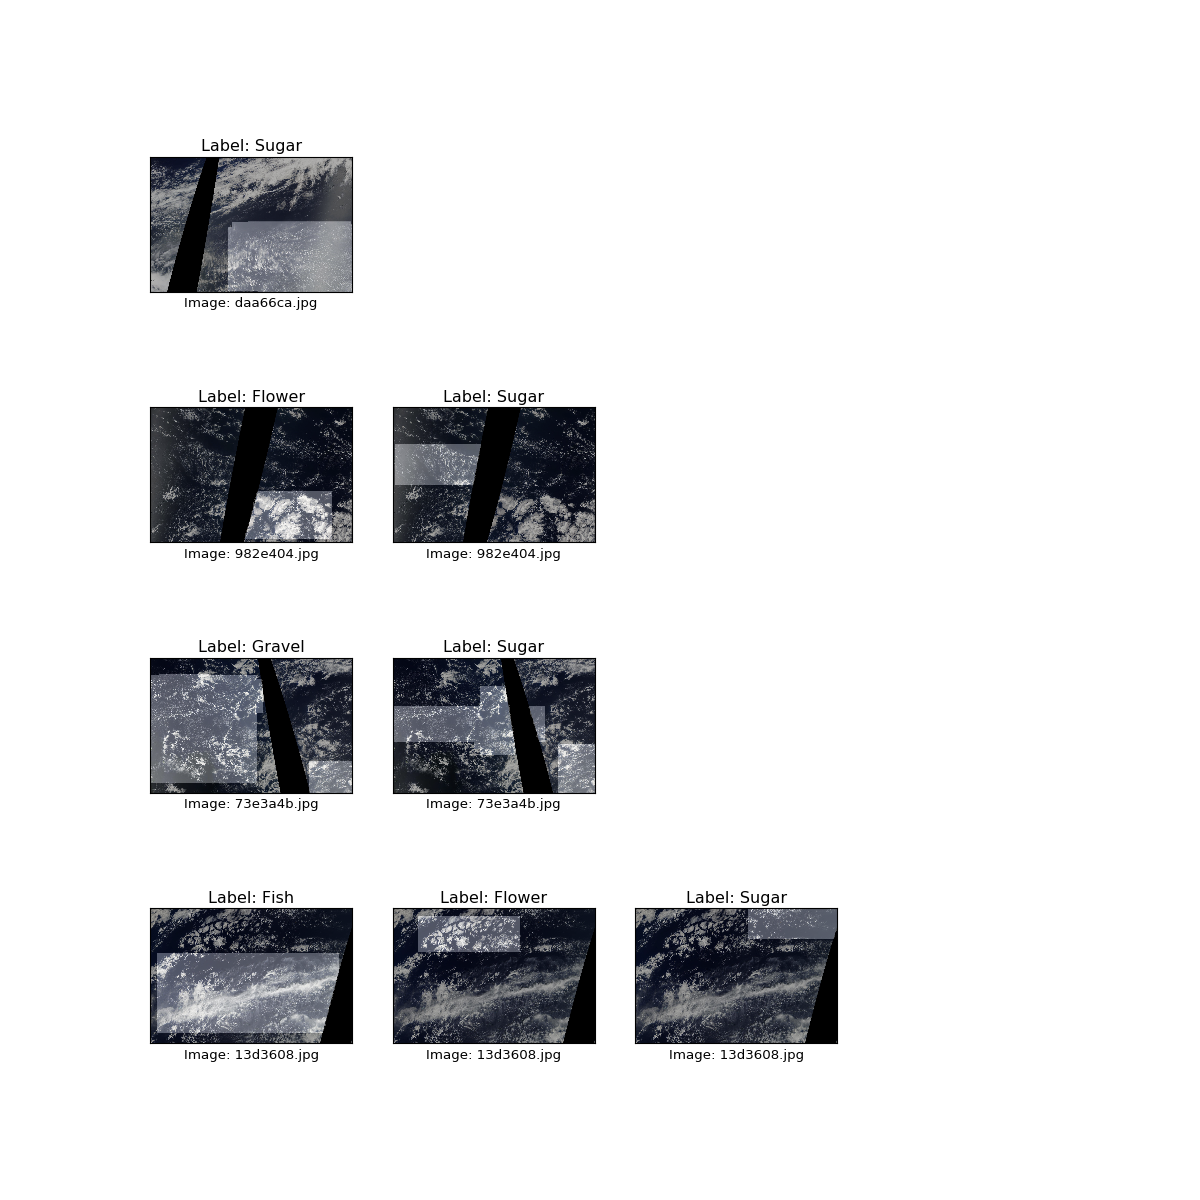

daa66ca.jpg
0
Image_Label                                      daa66ca.jpg_Sugar
EncodedPixels    1134731 660 1136131 660 1137531 660 1138931 66...
ImageId                                                daa66ca.jpg
ClassId                                                      Sugar
Name: 18875, dtype: object
982e404.jpg
0
Image_Label                                     982e404.jpg_Flower
EncodedPixels    1367761 4 1367766 2 1367769 2 1369161 1 136916...
ImageId                                                982e404.jpg
ClassId                                                     Flower
Name: 13349, dtype: object
1
Image_Label                                      982e404.jpg_Sugar
EncodedPixels    22796 421 24196 421 25596 421 26996 421 28396 ...
ImageId                                                982e404.jpg
ClassId                                                      Sugar
Name: 13351, dtype: object
73e3a4b.jpg
0
Image_Label                                     73e3a4b.jpg_Gravel
Enco

In [23]:
# Now plot random images with their masks
fig3 = plt.figure(figsize=(15, 15))
num3=4 # number of images we pick
# the following part looks for num3 random images
for index3, image_id3 in enumerate(np.random.choice(train_df['ImageId'].unique(), num3)):
    print(image_id3) # name of the image (without the path)
# find the labeled subimages from train_df
    for i3, (idx3, nrow3) in enumerate(train_df.loc[train_df['ImageId'] == image_id3].iterrows()):
        print(i3) # indices for how many labels are for this image
        print(nrow3) # the whole row with all the info from train_df
        ax3 = fig3.add_subplot(num3, 4, index3 * num3 + i3 + 1, xticks=[], yticks=[])
        random_image3_withpath=path1_train+image_id3
        image3=Image.open(random_image3_withpath)
        rle_mask3 = nrow3['EncodedPixels']
        mask3=rle2mask(rle_mask3,1400,2100)
        plt.xlabel('Image: {}'.format(image_id3))
        plt.title('Label: {}'.format(nrow3['ClassId']))
        plt.imshow(image3)
        plt.imshow(mask3, alpha=0.3, cmap='gray')   
        plt.show()

In [24]:
# The mask has only zero or 1. The zero points are the ones that do not belong
# in any mask, the ones that are 1 belong to one of the 4 labels.
print(mask3.max())
print(mask3.min())

1
0


### 3.4. Helper functions and classes for data generation

In [25]:
#    Reshape a numpy array, which is input_shape=(height, width), 
#    as opposed to input_shape=(width, height) for cv2

def np_resize(img, input_shape):
    
    height, width = input_shape
    return cv2.resize(img, (width, height))

In [26]:
def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

In [27]:
def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

In [28]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='train_images',
                 batch_size=32, dim=(1400, 2100), n_channels=3, reshape=None,
                 augment=False, n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.reshape = reshape
        self.n_channels = n_channels
        self.augment = augment
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()
        np.random.seed(self.random_state)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            
            if self.augment:
                X, y = self.__augment_batch(X, y)
            
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = {self.base_path}/{im_name}
            img = self.__load_rgb(img_path)
            
            if self.reshape is not None:
                img = np_resize(img, self.reshape)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.reshape, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            
            if self.reshape is not None:
                masks = build_masks(rles, input_shape=self.dim, reshape=self.reshape)
            else:
                masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img
    
    def __random_transform(self, img, masks):
        composition = albu.Compose([
            albu.HorizontalFlip(),
            albu.VerticalFlip(),
            albu.ShiftScaleRotate(rotate_limit=45, shift_limit=0.15, scale_limit=0.15)
        ])
        
        composed = composition(image=img, mask=masks)
        aug_img = composed['image']
        aug_masks = composed['mask']
        
        return aug_img, aug_masks
    
    def __augment_batch(self, img_batch, masks_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ], masks_batch[i, ] = self.__random_transform(
                img_batch[i, ], masks_batch[i, ])
        
        return img_batch, masks_batch


### 3.4. Prepare the training and validation data

In [29]:
train_df = pd.read_csv('Clouds/train.csv').fillna(-1)
train_df['ImageId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[0])
train_df['Label'] = train_df['Image_Label'].apply(lambda x: x.split('_')[1])
# lets create a dict with class id and encoded pixels and group all the defaults per image
train_df['Label_EncodedPixels'] = train_df.apply(lambda row: (row['Label'], row['EncodedPixels']), axis = 1)

In [30]:
train_image_ids = train_df['ImageId'].unique()

In [31]:
train_image_ids=mask_count_df['ImageId']
#print(train_image_ids)
X_train, X_val = train_test_split(train_image_ids, test_size=0.2, random_state=10)

In [32]:
# create a dict of all the masks
masks = {}
for index, row in train_df[train_df['EncodedPixels']!=-1].iterrows():
    masks[row['Image_Label']] = row['EncodedPixels']

In [33]:
params = {'img_h': 320,
          'img_w': 480,
          'image_dir': 'Clouds/train.csv',
          'batch_size': 32,
          'shuffle': True}

In [35]:
# Get Generators
train_generator = DataGenerator(X_train, masks, **params)
val_generator = DataGenerator(X_val, masks, **params)

### 3.5. Define the model and the dice coefficient metric

In [36]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [39]:
preprocess = get_preprocessing('resnet34')
model = Unet('resnet34', input_shape=(320, 480, 3), classes=4, activation='sigmoid')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

In [40]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 320, 480, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_35 (ZeroPadding2 (None, 326, 486, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 160, 240, 64) 9408        zero_padding2d_35[0][0]          
____________________________________________________________________________________________

### 3.6. Run model

In [41]:
# define new data array
train_df_n = pd.read_csv('Clouds/train.csv')
train_df_n['ImageId'] = train_df_n['Image_Label'].apply(lambda x: x.split('_')[0])
train_df_n['ClassId'] = train_df_n['Image_Label'].apply(lambda x: x.split('_')[1])
train_df_n['hasMask'] = ~ train_df_n['EncodedPixels'].isnull()

print(train_df_n.shape)
train_df_n.head()

mask_count_df = train_df_n.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

sub_df = pd.read_csv('Clouds/sample_submission.csv')
sub_df['ImageId'] = sub_df['Image_Label'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

(22184, 5)
(5546, 2)


In [42]:
BATCH_SIZE = 32

train_idx, val_idx = train_test_split(
    mask_count_df.index, random_state=2019, test_size=0.2
)

In [43]:
train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df_n,
    batch_size=BATCH_SIZE,
    reshape=(320, 480),
    augment=True,
    n_channels=3,
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df_n,
    batch_size=BATCH_SIZE, 
    reshape=(320, 480),
    augment=False,
    n_channels=3,
    n_classes=4
)

In [44]:
from segmentation_models import Unet


# LOAD UNET WITH PRETRAINING FROM IMAGENET
preprocess = sm.get_preprocessing('inceptionresnetv2') 
model = Unet('inceptionresnetv2', input_shape=(320, 480, 3), classes=4, activation='sigmoid')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

model.summary()
# save the outcome
checkpoint = ModelCheckpoint('model_inceptionresnetv2.h5', save_best_only=True)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    epochs=20
)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 240, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 160, 240, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 160, 240, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

### 3.7. Predictions

In [46]:
# Load the weights from the previous run and make predictions
model.load_weights('model_inceptionresnetv2.h5')
test_df = []
all_idx=list(range(0,test_imgs.shape[0],1))

test_generator = DataGenerator(all_idx,df=test_imgs,shuffle=False,
        mode='predict',dim=(350, 525),reshape=(320, 480),n_channels=3,
        base_path='test_images',target_df=sub_df,batch_size=1,n_classes=4)


batch_pred_masks = model.predict_generator(test_generator, workers=1,verbose=1)


In [48]:
for j, b in enumerate(all_idx):
        filename = test_imgs['ImageId'].iloc[b]
        image_df = sub_df[sub_df['ImageId'] == filename].copy()

        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))

        image_df_n['EncodedPixels'] = pred_rles
        test_df.append(image_df_n)

test_df = pd.concat(test_df)
test_df.drop(columns='ImageId', inplace=True)
test_df.to_csv('cloud_submission.csv', index=False)

In [49]:
# Submitted November 17, 2019

### 4. Improvements

Check the background illumination

Increase contrast

Grid search